In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sys

import hydroeval as he
import h5py
import pynhd as nhd
from matplotlib.colors import ListedColormap

sys.path.insert(0, '../')
from methods.processing import extract_loo_results_from_hdf5, get_upstream_gauges
from methods.processing.prep_loo import get_basin_catchment_area
from methods.diagnostics import get_error_summary

from methods.plotting.diagnostic_plots import plot_grid_metric_map, plot_Nx3_error_slope_cdf
from methods.plotting.diagnostic_plots import plot_error_cdf_subplot, plot_error_slope_subplot, plot_Nx1_binyear_boxplots
from methods.plotting.data_plots import plot_data_summary
from methods.utils.constants import cms_to_mgd, crs, cartesian_crs
from methods.diagnostics.metrics import error_metrics
from methods.processing.load import load_leave_one_out_datasets, load_gauge_matches, load_unmanaged_gauge_metadata

# Directories
from methods.utils.directories import pywrdrb_dir, path_to_nhm_data, path_to_nwm_data

# Comparison dates
start_date = '1983-10-01'
end_date = '2016-12-31'

K = 5
model_datasets = ['nhmv10', 'nwmv21', 'obs_pub_nhmv10', 'obs_pub_nwmv21', 'obs_pub_nhmv10_ensemble', 'obs_pub_nwmv21_ensemble']
single_datasets = ['nhmv10', 'nwmv21', 'obs_pub_nhmv10', 'obs_pub_nwmv21']
pub_datasets = ['obs_pub_nhmv10', 'obs_pub_nwmv21']
ensemble_datasets = ['obs_pub_nhmv10_ensemble', 'obs_pub_nwmv21_ensemble']
error_datasets = ['nhmv10', 'nwmv21', 
                  'obs_pub_nhmv10', 'obs_pub_nwmv21', 
                  'obs_pub_nhmv10_ensemble', 'obs_pub_nwmv21_ensemble'] 

model_colors = {
    'obs': 'black',
    'nhmv10' : 'indigo', 
    'nwmv21' : 'darkmagenta',
    'obs_pub_nhmv10' : 'firebrick', 
    'obs_pub_nhmv10_ensemble' : 'orangered', 
    'obs_pub_nwmv21' : 'steelblue', 
    'obs_pub_nwmv21_ensemble':'dodgerblue'
    }

model_labels = {
    'obs': 'Observed',
    'nhmv10' : 'NHMv1.0',
    'nwmv21' : 'NWMv2.1',
    'obs_pub_nhmv10' : 'PUB-NHM',
    'obs_pub_nhmv10_ensemble' : 'PUB-NHM Ensemble',
    'obs_pub_nwmv21' : 'PUB-NWM',
    'obs_pub_nwmv21_ensemble':'PUB-NWM Ensemble'
    }


fdc_quantiles = np.linspace(0.0001, 0.99999, 20)


In [2]:

#################
### Load data ###
#################

### Spatial
drb_boundary = gpd.read_file(f'{pywrdrb_dir}DRB_spatial/DRB_shapefiles/drb_bnd_polygon.shp').to_crs(crs)
drb_mainstem = gpd.read_file(f'{pywrdrb_dir}DRB_spatial/DRB_shapefiles/delawareriver.shp').to_crs(crs)
prediction_locations = pd.read_csv(f'../data/prediction_locations.csv', sep = ',', index_col=0)
prediction_locations = gpd.GeoDataFrame(prediction_locations, geometry=gpd.points_from_xy(prediction_locations.long, prediction_locations.lat))
    
## Streamflows
Q_observed = pd.read_csv(f'../data/USGS/drb_historic_unmanaged_streamflow_cms.csv', index_col=0, parse_dates=True)
Q = load_leave_one_out_datasets()
unmanaged_gauge_meta = load_unmanaged_gauge_metadata()
gauge_matches = load_gauge_matches()

loo_sites = Q['nhmv10'].columns.to_list()

print('Finding upstream gauges from LOO sites')
subcatchment_gauges = get_upstream_gauges(loo_sites, unmanaged_gauge_meta,
                                          simplify=True)

## Basin area geom
# Get catchment areas
basin_areas = np.zeros(len(loo_sites))
for i, site in enumerate(loo_sites):
    basin_areas[i] = get_basin_catchment_area(feature_id=site,
                                              feature_source='nwissite')
    
print(f'Ready to analyze {len(loo_sites)} LOO sites')

Loading all leave-one-out datasets...
Searching for upstream gauges for each site...
Finding upstream gauges from LOO sites
Searching for upstream gauges for each site...
Ready to analyze 42 LOO sites


In [3]:
## Get error metrics
recalculate_error_metrics = False
if recalculate_error_metrics:
    error_summary = get_error_summary(Q, error_datasets, 
                                            loo_sites,  
                                            start_date='1945-01-01', end_date='2016-12-31')
    error_summary.to_csv('../outputs/LOO/loo_error_summary.csv')

    error_summary_annual = get_error_summary(Q, error_datasets, 
                                            loo_sites, 
                                            by_year=True, 
                                            start_date='1945-01-01', end_date='2016-12-31')
    error_summary_annual.to_csv('../outputs/LOO/loo_error_summary_annual.csv')
else:
    error_summary = pd.read_csv('../outputs/LOO/loo_error_summary.csv', index_col=0)
    error_summary_annual = pd.read_csv('../outputs/LOO/loo_error_summary_annual.csv', index_col=0)
    

0          1983
1          1983
2          1983
3          1983
4          1983
           ... 
1123615    2015
1123616    2015
1123617    2015
1123618    2015
1123619    2015
Name: year, Length: 1123620, dtype: int64

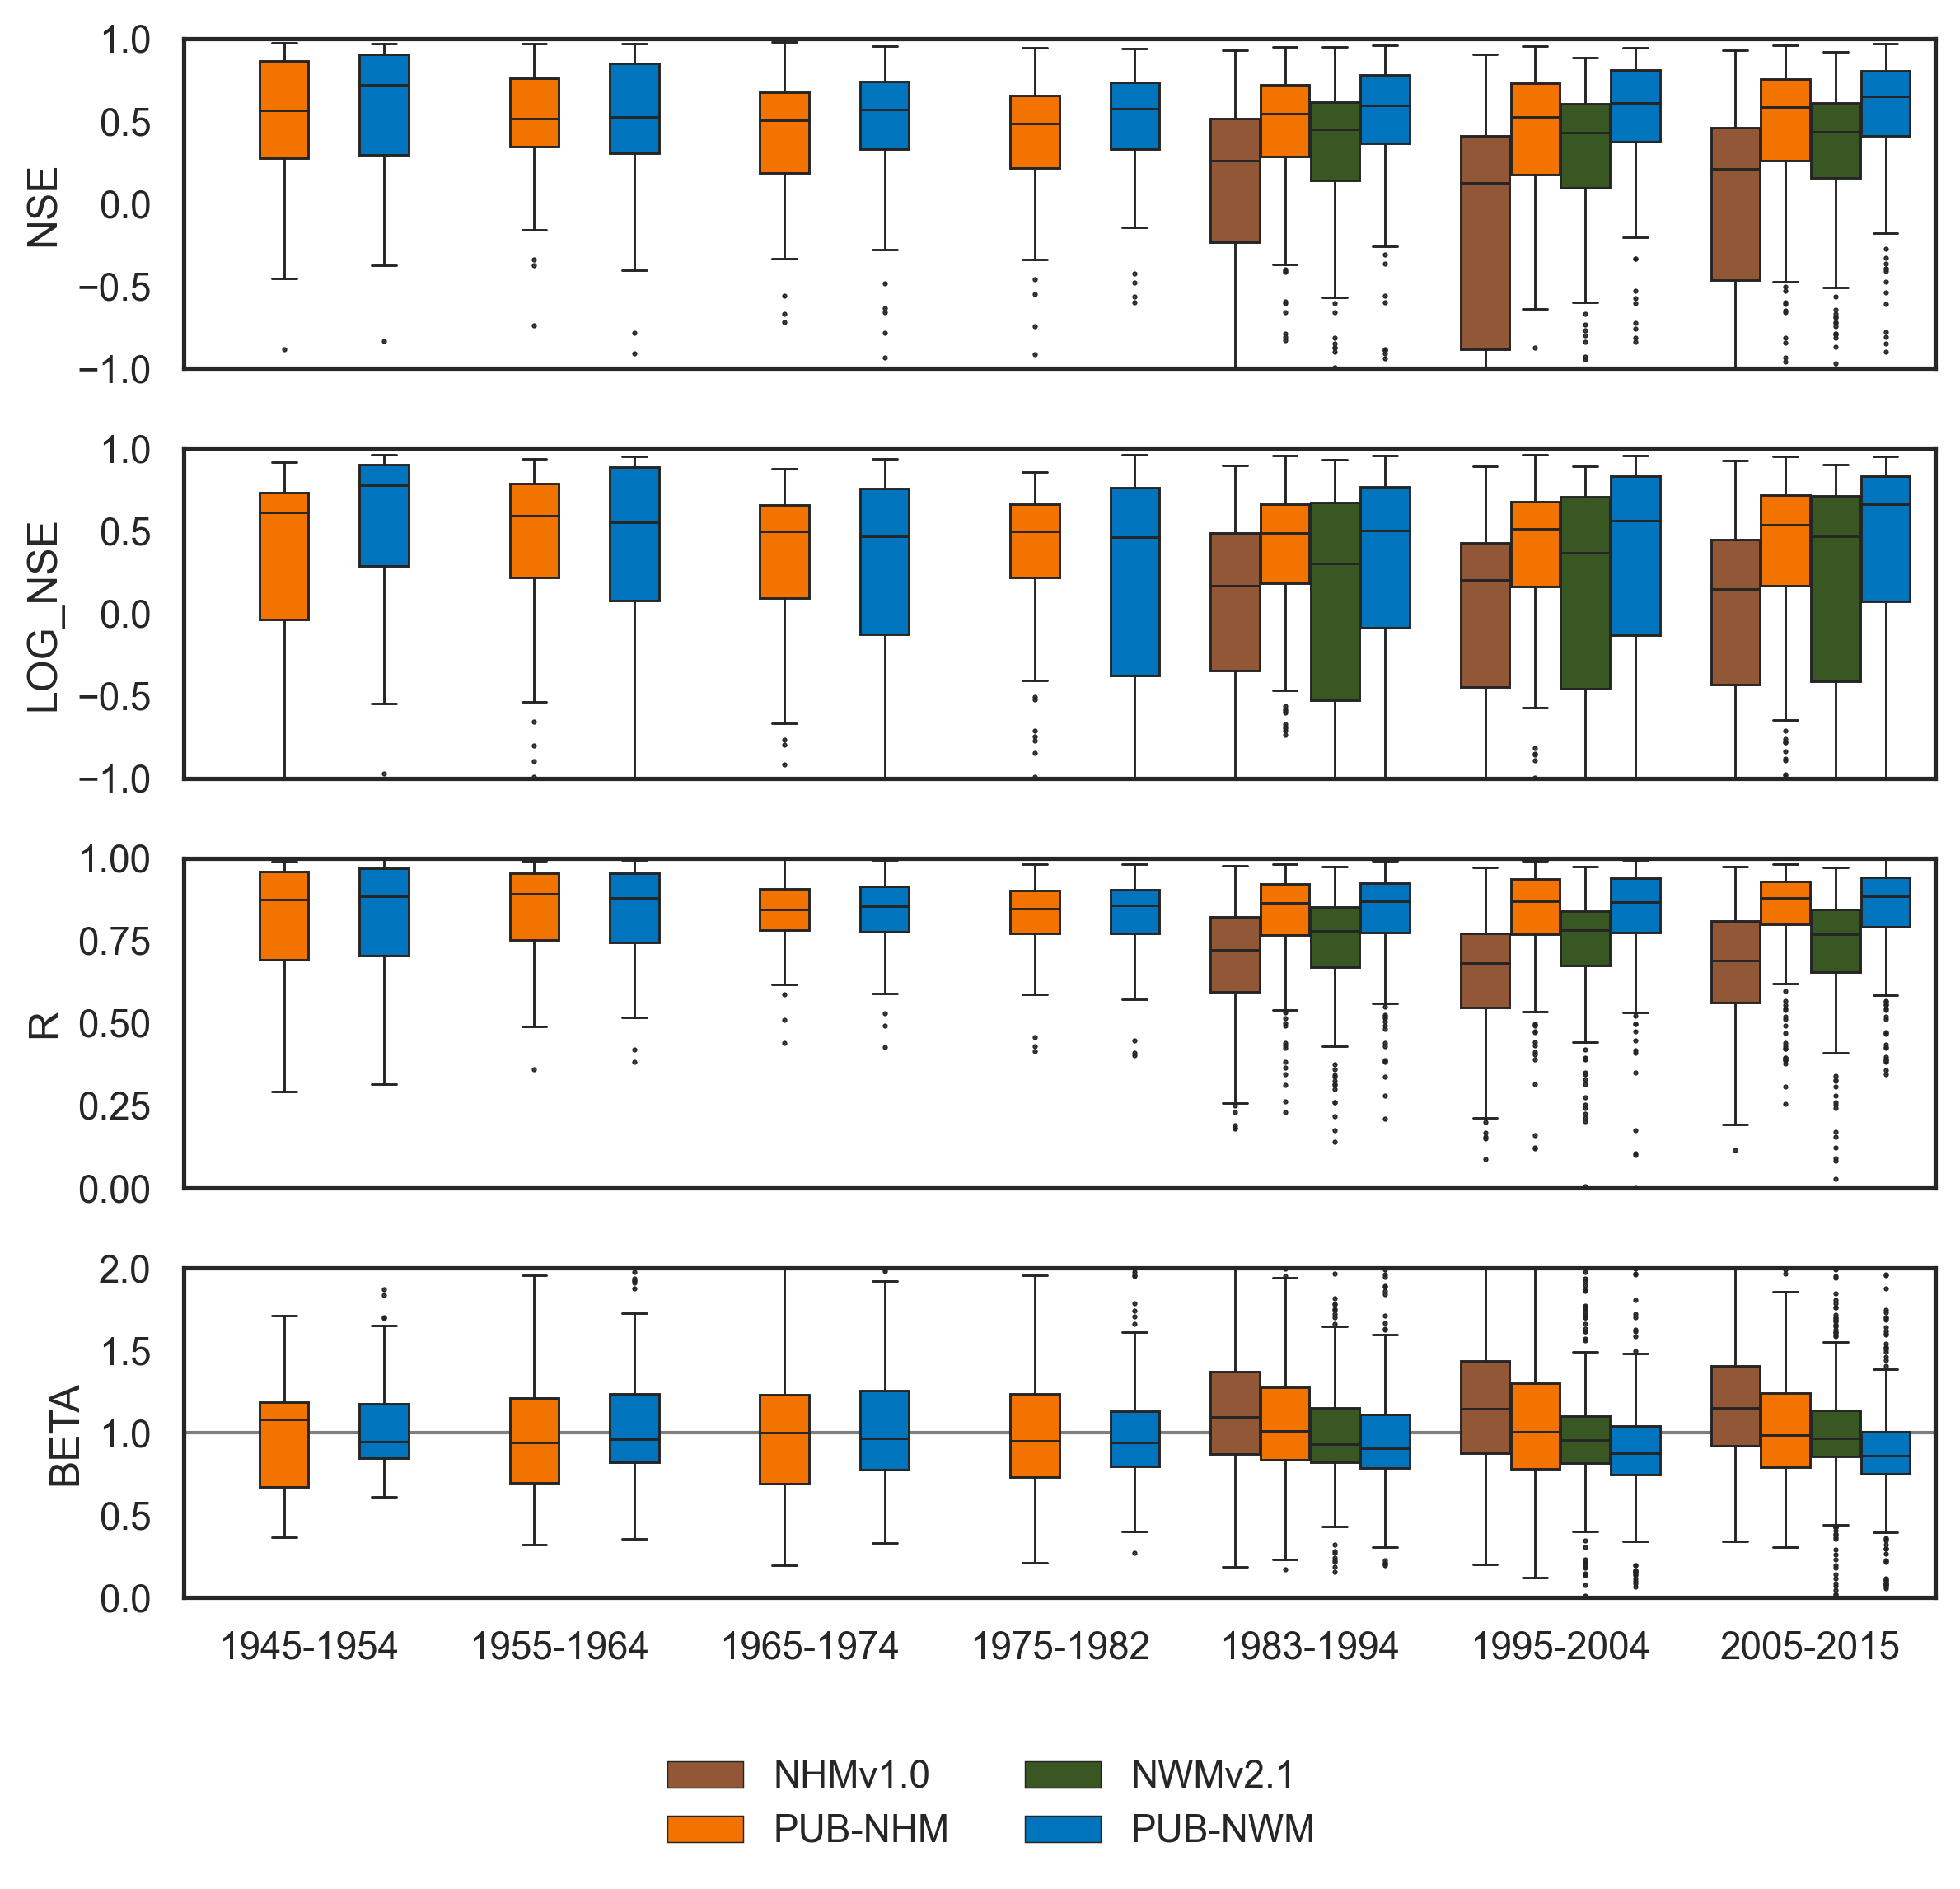

In [113]:
model_colors = {
    'obs': 'black',
    'nhmv10' : '#925736', 
    'nwmv21' : '#385723',
    'obs_pub_nhmv10' : '#F27300', 
    'obs_pub_nhmv10_ensemble' : '#FAD790', 
    'obs_pub_nwmv21' : '#0174BE', 
    'obs_pub_nwmv21_ensemble': '#9CD2F6'
    }

ideal_metric_scores = {'nse':1, 'kge':1, 'r':1, 'alpha':1, 'beta':1,
                       'log_nse':1, 'log_kge':1, 'log_r':1, 'log_alpha':1, 'log_beta':1, 
                       'Q0.1pbias':0.0, 'Q0.2pbias':0.0, 'Q0.3pbias':0.0, 
                       'AbsQ0.1pbias':0.0, 'AbsQ0.2pbias':0.0, 'AbsQ0.3pbias':0.0}
                
lower_bound_metric_scores = {'nse':-1, 'kge':-1, 'r':0.0, 'alpha':0, 'beta':0,
                       'log_nse':-1, 'log_kge':0, 'log_r':0.0, 'log_alpha':-1, 'log_beta':-1, 
                       'Q0.1pbias':-1, 'Q0.2pbias':-1, 'Q0.3pbias':-1, 
                       'AbsQ0.1pbias':0, 'AbsQ0.2pbias':0, 'AbsQ0.3pbias':0}

upper_bound_metric_scores = {'nse':1, 'kge':1, 'r':1, 'alpha':2, 'beta':2,
                       'log_nse':1, 'log_kge':1, 'log_r':1, 'log_alpha':2, 'log_beta':2, 
                       'Q0.1pbias':1, 'Q0.2pbias':1, 'Q0.3pbias':1, 
                       'AbsQ0.1pbias':3, 'AbsQ0.2pbias':3, 'AbsQ0.3pbias':3}

def group_metric_data_yearbin(error_summary_annual, bin_size, metric):
    # Filter the DataFrame for the 'nse' metric
    metric_data = error_summary_annual[error_summary_annual['metric'] == metric]
    metric_data = metric_data.dropna(subset=['value'])

    # Bin the years into N-year bins
    year_min, year_max = 1945, 2022  # Define your min and max years
    bins = range(year_min, year_max + bin_size, bin_size)  # Create bins
    labels = [f'{i}-{i + bin_size - 1}' for i in bins[:-1]]  # Create labels for bins
    
    bins = np.array([1945, 1955, 1965, 1975, 1983, 1995, 2005, 2016])
    labels = [f'{bins[i]}-{bins[i+1]-1}' for i in range(len(bins)-1)]

    
    metric_data['year_bin'] = pd.cut(metric_data['year'], bins=bins, labels=labels, right=False)

    # Ensure the 'value' column is numeric
    metric_data['value'] = pd.to_numeric(metric_data['value'], errors='coerce')

    # Drop NaNs that were coerced during the numeric conversion
    metric_data.dropna(subset=['value'], inplace=True)
    
    return metric_data


def plot_binyear_boxplot_subplot(error_summary_annual, 
                                 ax, model_colors, 
                                 metric='nse', bin_size=10,
                                 plot_ensembles= False,
                                 ideal_metric_scores=ideal_metric_scores,
                                 lower_bound_metric_scores=lower_bound_metric_scores, 
                                 upper_bound_metric_scores=upper_bound_metric_scores,
):
    """Make a seaborn box plot of errors by year bin and model
    """

    metric_data = group_metric_data_yearbin(error_summary_annual, 
                                                    bin_size=bin_size, metric=metric)
    
    
    if plot_ensembles:
        model_hue_order = ['nhmv10', 'obs_pub_nhmv10_ensemble', 'obs_pub_nhmv10',  
                           'nwmv21', 'obs_pub_nwmv21_ensemble', 'obs_pub_nwmv21']
    else:
        model_hue_order = ['nhmv10', 'obs_pub_nhmv10', 
                           'nwmv21', 'obs_pub_nwmv21']
    flierprops = dict(marker='o', markerfacecolor='k', markersize=0.5,
                    linestyle='none')
    
    sns.boxplot(y="value", x="year_bin", hue="model", 
                hue_order = model_hue_order,
                data=metric_data, 
                palette=model_colors,
                saturation=1,
                linewidth=0.7,
                flierprops = flierprops,
                ax=ax)

    # add horizontal line across full boxplot area
    ax.axhline(ideal_metric_scores[metric], 
               ls='-', color='black', linewidth=1, 
               alpha=0.5, 
               zorder=0)
    ax.set_ylabel(metric.upper())
    ax.set_xlabel('')

    ax.legend().set_visible(False)
    ax.set_ylim([lower_bound_metric_scores[metric],
                 upper_bound_metric_scores[metric]])
    # Turn off axis boarder box
    # ax.spines["top"].set_visible(False)
    # ax.spines["right"].set_visible(False)
    # ax.spines["bottom"].set_visible(False)
    
    # ax.grid(which='major', axis='y', linestyle='-', alpha=0.5)
    
    return ax




# Test
def plot_Nx1_binyear_boxplots(error_summary_annual, 
                              metrics, model_colors,
                              ideal_metric_scores=ideal_metric_scores,
                              lower_bound_metric_scores=lower_bound_metric_scores,
                              upper_bound_metric_scores=upper_bound_metric_scores,
                              bin_size=10, plot_ensembles= True):

    NROWS = len(metrics)
    # Set up the matplotlib figure and aesthetics
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    
    fig, axs = plt.subplots(nrows=NROWS, ncols=1, 
                            figsize=(8, (NROWS*1.75)), 
                            dpi = 300, sharex=True)
    for i, metric in enumerate(metrics):
        ax = axs[i]
        plot_binyear_boxplot_subplot(error_summary_annual, ax, model_colors,
                                    metric=metric, bin_size=bin_size,
                                    plot_ensembles=plot_ensembles)
    
    # Make a single legend for the whole plot
    handles, labels = ax.get_legend_handles_labels()
    # Fix labels
    labels = [model_labels[label] for label in labels]
    
    fig.legend(handles, labels, loc='lower center', ncol=2, 
               bbox_to_anchor=(0.5, -0.1), frameon=False)
    
    
    plt.tight_layout()
    plt.show()
    return 

use_metrics = ['nse', 'log_nse', 'r', 'beta']

plot_Nx1_binyear_boxplots(error_summary_annual,
                          use_metrics, model_colors,
                            bin_size=10, plot_ensembles=False)

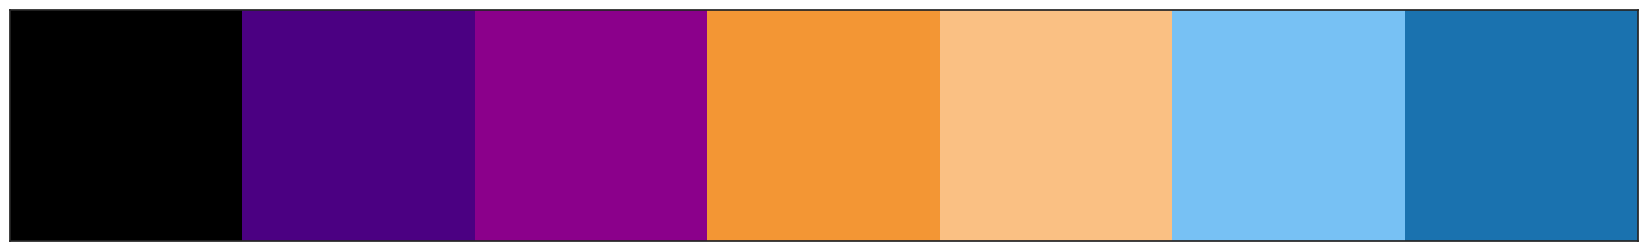

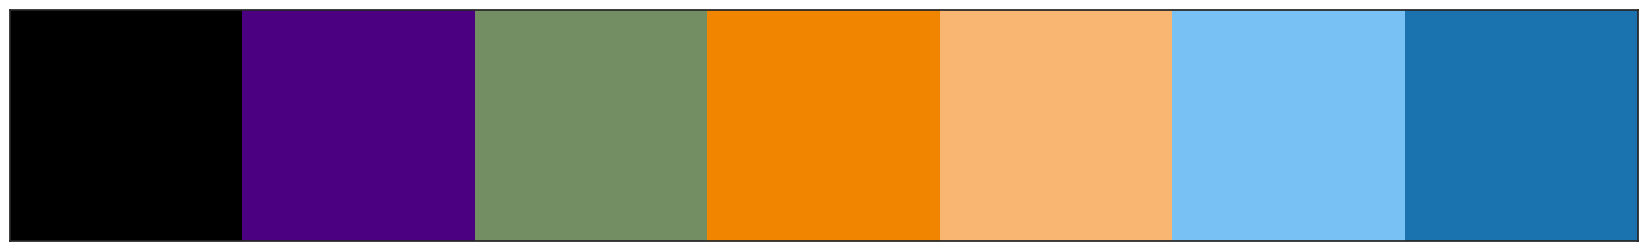

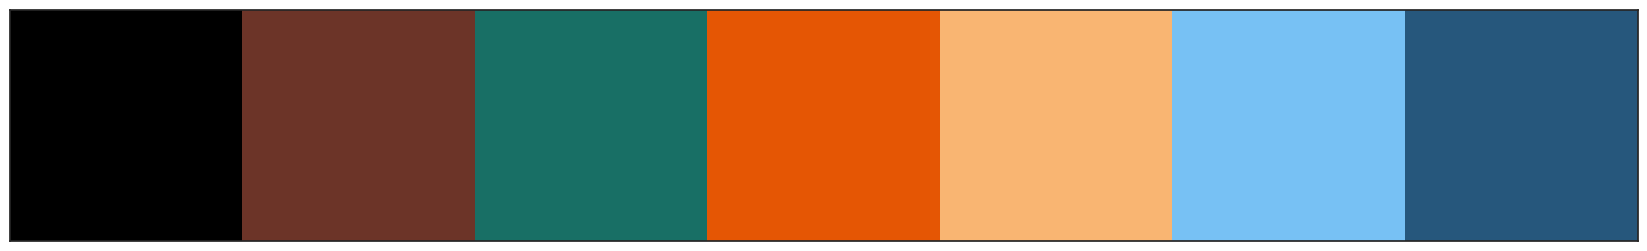

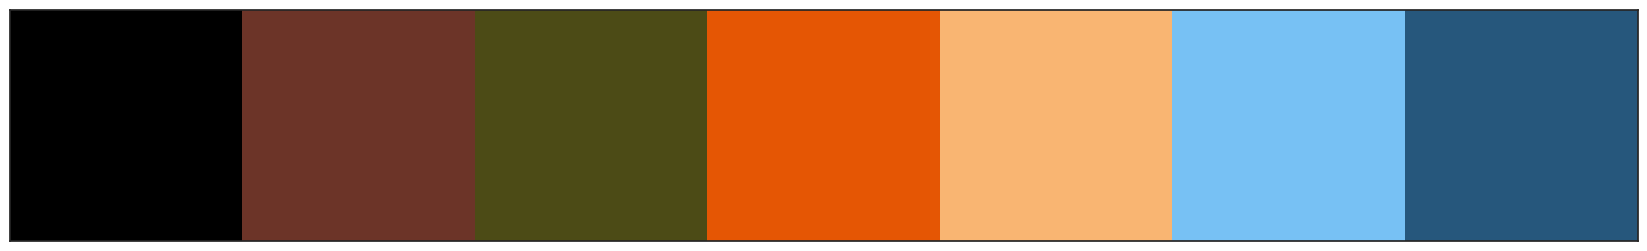

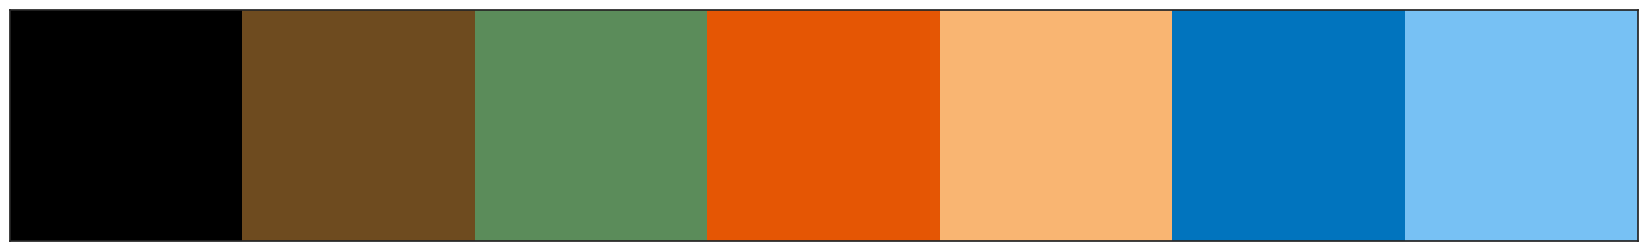

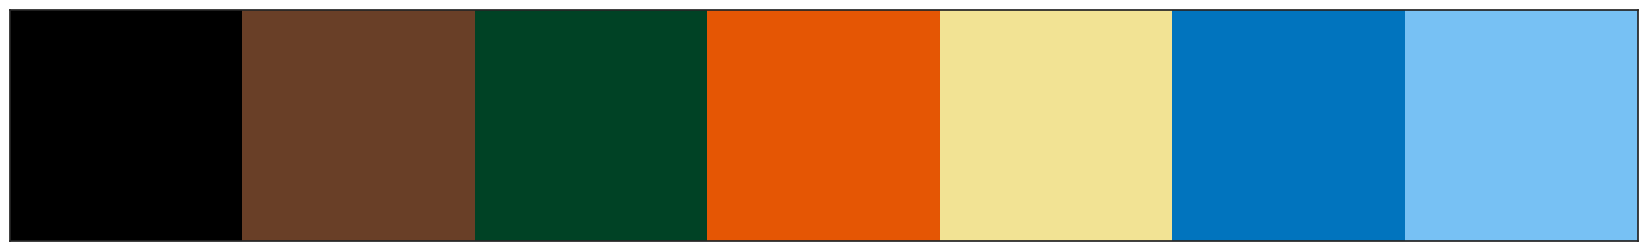

In [114]:

# Make 2x3 grid of colors using matplotlib. 
# The top row is [nhmv10, obs_pub_nhmv10, obs_pub_nhmv10_ensemble]
# The bottom row is [nwmv21, obs_pub_nwmv21, obs_pub_nwmv21_ensemble]
# colors taken from model_colors dictionary
# testing palette

model_colors = {
    'obs': 'black',
    'nhmv10' : 'indigo', 
    'nwmv21' : 'darkmagenta',
    'obs_pub_nhmv10' : '#F39634', 
    'obs_pub_nhmv10_ensemble' : '#FAC083', 
    'obs_pub_nwmv21' : '#77C1F4', 
    'obs_pub_nwmv21_ensemble':'#1A72AF'
    }


sns.palplot(model_colors.values(), size=3)


model_colors = {
    'obs': 'black',
    'nhmv10' : 'indigo', 
    'nwmv21' : '#748E63',
    'obs_pub_nhmv10' : '#f28500', 
    'obs_pub_nhmv10_ensemble' : '#F9B572', 
    'obs_pub_nwmv21' : '#77C1F4', 
    'obs_pub_nwmv21_ensemble':'#1A72AF'
    }


sns.palplot(model_colors.values(), size=3)

model_colors = {
    'obs': 'black',
    'nhmv10' : '#6C3428', 
    'nwmv21' : '#186F65',
    'obs_pub_nhmv10' : '#E55604', 
    'obs_pub_nhmv10_ensemble' : '#F9B572', 
    'obs_pub_nwmv21' : '#77C1F4', 
    'obs_pub_nwmv21_ensemble':'#26577C'
    }


sns.palplot(model_colors.values(), size=3)

model_colors = {
    'obs': 'black',
    'nhmv10' : '#6C3428', 
    'nwmv21' : '#4C4B16',
    'obs_pub_nhmv10' : '#E55604', 
    'obs_pub_nhmv10_ensemble' : '#F9B572', 
    'obs_pub_nwmv21' : '#77C1F4', 
    'obs_pub_nwmv21_ensemble':'#26577C'
    }


sns.palplot(model_colors.values(), size=3)

model_colors = {
    'obs': 'black',
    'nhmv10' : '#6E4B1F', 
    'nwmv21' : '#5B8C5A',
    'obs_pub_nhmv10' : '#E55604', 
    'obs_pub_nhmv10_ensemble' : '#F9B572', 
    'obs_pub_nwmv21' : '#0174BE', 
    'obs_pub_nwmv21_ensemble': '#77C1F4'
    }
sns.palplot(model_colors.values(), size=3)
model_colors = {
    'obs': 'black',
    'nhmv10' : '#693F27', 
    'nwmv21' : '#004225',
    'obs_pub_nhmv10' : '#E55604', 
    'obs_pub_nhmv10_ensemble' : '#F2E394', 
    'obs_pub_nwmv21' : '#0174BE', 
    'obs_pub_nwmv21_ensemble': '#77C1F4'
    }
sns.palplot(model_colors.values(), size=3)

(2.0, 0.0)

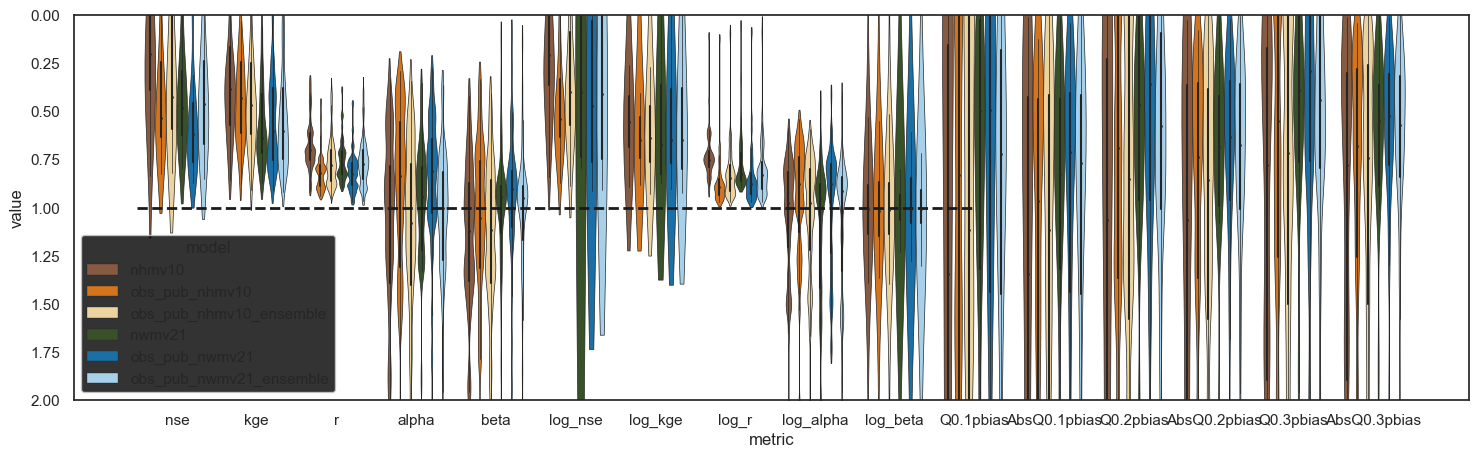

In [101]:


fig, ax = plt.subplots(figsize=(18, 5))
sns.violinplot(data=error_summary,
               x='metric', y='value', hue='model', inner='box', 
               ax=ax,
               hue_order= ['nhmv10', 'obs_pub_nhmv10', 'obs_pub_nhmv10_ensemble', 'nwmv21', 'obs_pub_nwmv21', 'obs_pub_nwmv21_ensemble'],
               palette=model_colors, 
               linewidth=0.5,
               cut=1.0, bw=0.15, scale='width', alpha=0.5) 

# for i,model in enumerate(['nhmv10', 'obs_pub_nhmv10', 'nwmv21', 'obs_pub_nwmv21']):
#     plt.scatter(x=np.ones(len(loo_sites))*i*0.2-0.3, y=loo_summary[model].loc[:, metric], 
#                 s=75, alpha=0.2, color='k')

ax.hlines(1, -0.5, 10, color='k', linestyle='--', linewidth=2)
ax.set_ylim([2, 0])

In [ ]:
test_site = loo_sites[1]
n_bootstrap = 1000
x=7
N=10

seven_q10, lower_7q10, upper_7q10 = calculate_xQN_with_bootstrap(Q['obs_pub_nhmv10'].loc[start_date:end_date, test_site],x=x, N=N)
print(f'7Q10 for PUB-NHM is: {seven_q10} with CI: {lower_7q10} - {upper_7q10}')

seven_q10, lower_7q10, upper_7q10 = calculate_xQN_with_bootstrap(Q['obs_pub_nwmv21'].loc[start_date:end_date, test_site],x=x, N=N)
print(f'7Q10 for PUB-NWM is: {seven_q10} with CI: {lower_7q10} - {upper_7q10}')

seven_q10, lower_7q10, upper_7q10 = calculate_xQN_with_bootstrap(Q['nhmv10'].loc[start_date:end_date, test_site],x=x, N=N)
print(f'7Q10 for NHM is: {seven_q10} with CI: {lower_7q10} - {upper_7q10}')

seven_q10, lower_7q10, upper_7q10 = calculate_xQN_with_bootstrap(Q['nwmv21'].loc[start_date:end_date, test_site],x=x, N=N)
print(f'7Q10 for NWM is: {seven_q10} with CI: {lower_7q10} - {upper_7q10}')

seven_q10, lower_7q10, upper_7q10 = calculate_xQN_with_bootstrap(Q['obs'].loc[start_date:end_date, f'USGS-{test_site}'],x=x, N=N)
print(f'7Q10 for Obs is: {seven_q10} with CI: {lower_7q10} - {upper_7q10}')